# Monte Carlo Methods - Prediction 

### 5.1. Blackgame Problem

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [3]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [11]:
env.action_space.sample()

1

In [13]:
env.step(1)

((23, 2, False), -1, True, {})

For the below sample:  
- The action was 1 (hit)  
- The resulting state was (23, 2, False), -1, True. 

Meaning that our sum was 23, the dealer has a visible 2, we don't have an usable ace.  
Since we are over 21, we lost the game and the reward is -1; and the game is finished (True).

### Evaluate the random policy

The following code runs N episodes and show how state, actions and reward are obtained from the OpenAI environment

In [18]:
N = 3
for i_episode in range(N):
    state = env.reset()
    while True:
        print(state)
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(20, 3, False)
End game! Reward:  1.0
You won :)

(13, 1, True)
End game! Reward:  -1.0
You lost :(

(20, 1, False)
End game! Reward:  -1
You lost :(



### Evaluate a given policy

Let's evaluate the following policy:  

The player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [19]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

The algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output the Q-Table:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [20]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    
    # Initialize to zero the Total (summed) Return for each state-action
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Initialize to zero the counter for every visit to each cell in the Q-table
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Initialize to zero the value for every cell in the Q-table
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # For each of the episodes run
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Run the episode of the MDP and extract the values 
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        
        # Create the vector of discounts to be applied to the reward of each state
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        # Update the values
        for i, state in enumerate(states):
            
            # R(s,a) = SUM(discounted rewards)
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            
            # Increment the counter of visited states for that pair, N(s,a)
            N[state][actions[i]] += 1.0 
            
            # Calculate the Q(s,a) value given the total Return R(s,a) and the times visited N(s,a)
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
        
    return Q

### Run episodes and calculate $Q$-Table

we run our defined policy for N episodes and keep updating iteratively the values of the table when the pairs ```(s,a)```are visited. The corresponding state-values are plotted

Episode 500000/500000.

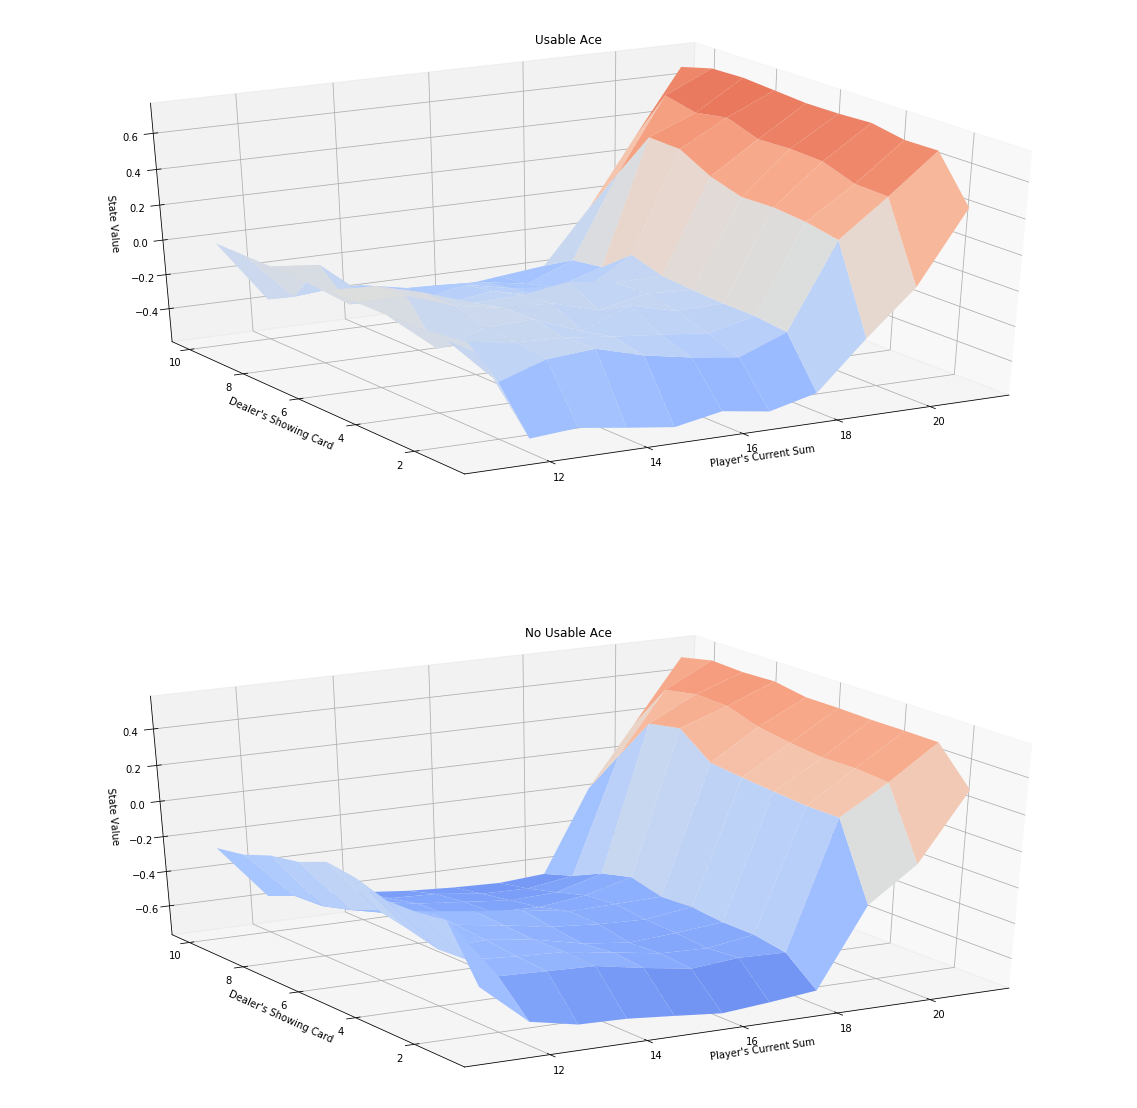

In [21]:
# Obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# Obtain-back the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# Plot the state-value function
plot_blackjack_values(V_to_plot)